In [83]:
import numpy as np 
import pandas as pd
from numpyro.diagnostics import summary
from utils.helpers import pickle_load
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

In [84]:
KEYS = ['sigma8', 'Omegac', 'Omegab', 'hubble', 'ns',
        'm1', 'm2', 'm3', 'm4',
        'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
        'a_ia', 'eta',
        'b1', 'b2', 'b3', 'b4', 'b5', 
        'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5']

# weight    
# minuslogpost          
# sigma8          
# omegac          
# omegab          
# hubble              
# ns              
# m1              
# m2              
# m3              
# m4         
# dz_wl_1         
# dz_wl_2         
# dz_wl_3         
# dz_wl_4            
# a_ia             
# eta              
# b1              
# b2              
# b3              
# b4              
# b5         
# dz_gc_1         
# dz_gc_2         
# dz_gc_3         
# dz_gc_4         
# dz_gc_5   
# minuslogprior 
# minuslogprior__0            
# chi2 
# chi2__my_likelihood

In [85]:
def summary_calculation(samples1: np.ndarray, samples2: np.ndarray, neval: int) -> pd.DataFrame:
    record = []
    for i, key in enumerate(KEYS):
        testsamples = np.vstack(([samples1[:,i], samples2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['scaled_n_eff'] = record_df['n_eff'] / neval
    return record_df

## Cobaya

In [86]:
def cobaya_statistics(engine = 'jaxcosmo', thin: int = 2, nchain = 2, method = 'nsamples'):
    record_samples = []
    nsamples_per_chain = []
    total_samples = 0
    for i in range(nchain):
        samples = np.loadtxt(f'outputcobaya/testing/{engine}_{i+1}/output_prefix.1.txt')
        total_samples += sum(samples[:,0])
        samples_thinned = samples[0::thin]
        record_samples.append(samples_thinned[:,2:-4])
        nsamples_per_chain.append(samples_thinned.shape[0])
    
    minsamples = min(nsamples_per_chain)
    
    if method == 'nsamples':
        stats = summary_calculation(record_samples[0][-minsamples:], record_samples[1][-minsamples:], 2*minsamples)
    else:
        stats = summary_calculation(record_samples[0][-minsamples:], record_samples[1][-minsamples:], total_samples)
    return stats

## EMCEE

In [87]:
def emcee_stats(engine = 'jaxcosmo', thin: int = 2, discard: int = 1000, method = 'nsamples'):

    test_1 = pickle_load('samples', f'{engine}_emcee_1')
    test_2 = pickle_load('samples', f'{engine}_emcee_2')

    nevals = test_1.flatchain.shape[0] + test_2.flatchain.shape[0]

    samples_1 = test_1.get_chain(discard = discard, thin = thin, flat = True) 
    samples_2 = test_2.get_chain(discard = discard, thin = thin, flat = True)
    
    if method == 'nsamples':
        stats = summary_calculation(samples_1, samples_2, samples_1.shape[0] + samples_2.shape[0])
    else:
        stats = summary_calculation(samples_1, samples_2, nevals) 
    return stats

## NUTS

In [88]:
def nuts_stats(engine = 'jaxcosmo', thin = None, method = 'nsamples'):

    sampler = pickle_load('samples', f'{engine}_nuts_small_ss_high_td')
    nsamples = sampler.num_chains * sampler.num_samples
    num_steps = sampler.get_extra_fields(group_by_chain=True)['num_steps'].sum(1).sum(0).item()
    samples = sampler.get_samples(group_by_chain=True)
    record = []
    for key in KEYS:
        parameter_samples = samples[key]
        if thin is not None:
            parameter_samples = parameter_samples[:,0::thin]
            nsamples = np.prod(parameter_samples.shape)
        summary_stats = summary(parameter_samples)
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    if method == 'nsamples':
        record_df['scaled_n_eff'] = record_df['n_eff'] / nsamples
    else:
        record_df['scaled_n_eff'] = record_df['n_eff'] / num_steps
    return record_df


In [89]:
METHOD = 'nsamples' 

In [90]:
factors = np.arange(2, 12, 2)
record_cobaya_jc = []
record_emcee_jc = []

record_cobaya_emu = []
record_emcee_emu = []

record_nuts_jc = []
record_nuts_emu = []

for t in factors:
    sneff_cobaya_jc = cobaya_statistics(engine='jaxcosmo', thin = t, method = METHOD)['scaled_n_eff'].mean()
    sneff_emcee_jc = emcee_stats(engine='jaxcosmo', thin = t, method = METHOD)['scaled_n_eff'].mean()
    sneff_nuts_jc = nuts_stats(engine = 'jaxcosmo', thin = t, method = METHOD)['scaled_n_eff'].mean()
    
    sneff_cobaya_emu = cobaya_statistics(engine='emulator', thin = t, method = METHOD)['scaled_n_eff'].mean()
    sneff_emcee_emu = emcee_stats(engine='emulator', thin = t, method = METHOD)['scaled_n_eff'].mean()
    sneff_nuts_emu = nuts_stats(engine = 'emulator', thin = t, method = METHOD)['scaled_n_eff'].mean()
    
    
    record_cobaya_jc.append(sneff_cobaya_jc)
    record_emcee_jc.append(sneff_emcee_jc)
    record_nuts_jc.append(sneff_nuts_jc)
    
    record_cobaya_emu.append(sneff_cobaya_emu)
    record_emcee_emu.append(sneff_emcee_emu)
    record_nuts_emu.append(sneff_nuts_emu)
    
record_cobaya_jc = np.asarray(record_cobaya_jc)
record_emcee_jc = np.asarray(record_emcee_jc)
record_nuts_jc = np.asarray(record_nuts_jc)

record_cobaya_emu = np.asarray(record_cobaya_emu)
record_emcee_emu = np.asarray(record_emcee_emu)
record_nuts_emu = np.asarray(record_nuts_emu)

In [106]:
ref = record_cobaya_jc[-1]

In [107]:
record_emcee_emu[-1] / ref

4.960578781160426

In [108]:
record_emcee_jc[-1] / ref

4.44733337266822

In [109]:
record_nuts_jc[-1] / ref

4.937674932210941

In [110]:
record_nuts_emu[-1] / ref

4.872417533897912

In [111]:
record_cobaya_emu[-1] / ref

1.0275921080205332

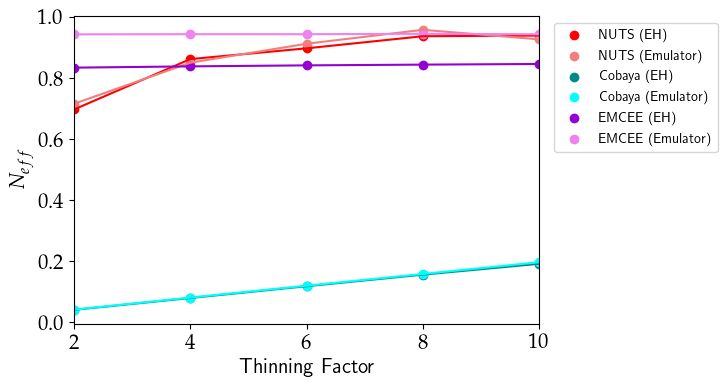

In [120]:
plt.figure(figsize = (6, 4))

plt.scatter(factors, record_nuts_jc, color = 'red', label = 'NUTS (EH)')
plt.plot(factors, record_nuts_jc, color = 'red')

plt.scatter(factors, record_nuts_emu, color = 'lightcoral', label = 'NUTS (Emulator)')
plt.plot(factors, record_nuts_emu, color = 'lightcoral')

plt.scatter(factors, record_cobaya_jc, color = 'darkcyan', label = 'Cobaya (EH)')
plt.plot(factors, record_cobaya_jc, color = 'darkcyan')

plt.scatter(factors, record_cobaya_emu, color = 'cyan', label = 'Cobaya (Emulator)')
plt.plot(factors, record_cobaya_emu, color = 'cyan')

plt.scatter(factors, record_emcee_jc, color = 'darkviolet', label = 'EMCEE (EH)')
plt.plot(factors, record_emcee_jc, color = 'darkviolet')

plt.scatter(factors, record_emcee_emu, color = 'violet', label = 'EMCEE (Emulator)')
plt.plot(factors, record_emcee_emu, color = 'violet')

plt.xlim(2, 10)
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Thinning Factor', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(bbox_to_anchor=[1.4, 1.0],prop={'family':'sans-serif', 'size':10})
# plt.savefig(f'/home/arrykrishna/Desktop/{ENGINE}_nsamples.pdf', bbox_inches = 'tight')
plt.show()

## Understand What Thinning Does

https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html


<img src="notes/thinning.png" 
     align="center" 
     width="800" />

In [93]:
# generate two chains (samples from a unit normal distribution)
nsamples = 100000
x1 = np.random.randn(nsamples)
x2 = np.random.randn(nsamples)
x = np.vstack([x1, x2])

In [94]:
# this is the effective sample size 
summary(x)['Param:0']['n_eff']

200713.31363885544

In [95]:
# this is the effective sample size per sample 
summary(x)['Param:0']['n_eff'] / (2*nsamples)

1.0035665681942771

In [96]:
thin_factors = np.arange(2, 102, 2)
record_neff = [] 
record_neff_n = []
for t in thin_factors:
    x1_thinned = x1[0::t]
    x2_thinned = x2[0::t]
    x_thinned = np.vstack([x1_thinned, x2_thinned])
    neff = summary(x_thinned)['Param:0']['n_eff']
    neff_n = neff / (x1_thinned.shape[0] + x2_thinned.shape[0])
    record_neff.append(neff)
    record_neff_n.append(neff_n)

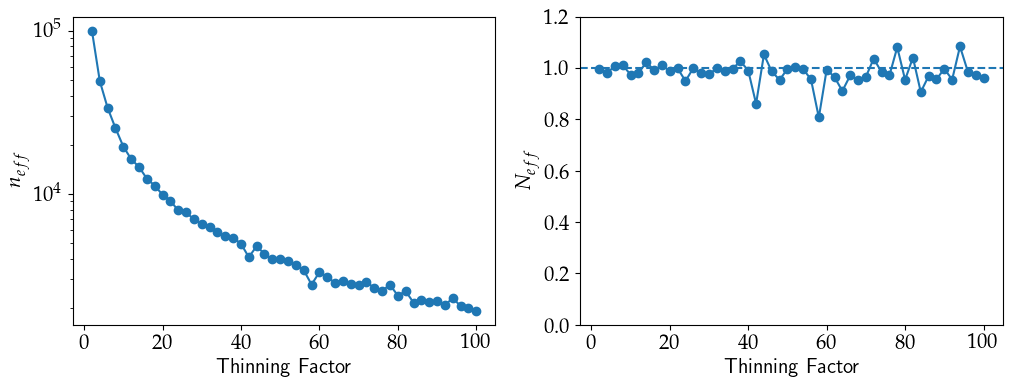

In [112]:
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.scatter(thin_factors, record_neff)
plt.plot(thin_factors, record_neff)
plt.yscale('log')
plt.ylabel(r'$n_{eff}$', fontsize = fontSize)
plt.xlabel(r'Thinning Factor', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
plt.scatter(thin_factors, record_neff_n)
plt.plot(thin_factors, record_neff_n)
plt.axhline(1.0, linestyle = '--')
plt.ylim(0, 1.2)
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Thinning Factor', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()